<a href="https://colab.research.google.com/github/hayden-huynh/Facial-Expression-Image-Classifier/blob/master/Facial_Expression_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download the facial expression dataset from Kaggle
# Reference 1: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

# Ref 1 starts =====
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download samaneheslamifar/facial-emotion-expressions
! unzip facial-emotion-expressions.zip
# ===== Ref 1 ends

In [ ]:
# Label the dataset images into csv files

import os
import csv

label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

train_csv = open("train_labels.csv", "w")
train_writer = csv.writer(train_csv)
test_csv = open("test_labels.csv", "w")
test_writer = csv.writer(test_csv)

train_root = "/content/images/train"
for label in sorted(os.listdir(train_root)):
  for img in sorted(os.listdir(os.path.join(train_root, label))):
    train_writer.writerow([os.path.join(label, img), label_map[label]])

test_root = "/content/images/validation"
for label in sorted(os.listdir(test_root)):
  for img in sorted(os.listdir(os.path.join(test_root, label))):
    test_writer.writerow([os.path.join(label, img), label_map[label]])


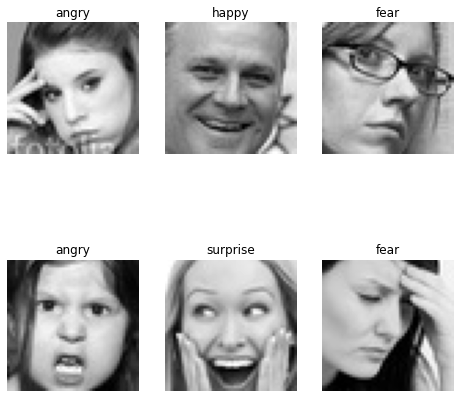

In [ ]:
# Create training and testing datasets
# Reference 2: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Reference 3: https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html

# Ref 2 starts =====
import os
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import matplotlib.pyplot as plt

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]


# Custom dataset class
class FacialExpDataset(Dataset):
  def __init__(self, labels_csv, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(labels_csv)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path).float()
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

# Load the images into the datasets
# Ref 3 starts =====
one_hot_transform = Lambda(lambda y: torch.zeros(
    7, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# ===== Ref 3 ends
train_data = FacialExpDataset("/content/train_labels.csv", train_root, 
                              target_transform=one_hot_transform)
test_data = FacialExpDataset("/content/test_labels.csv", test_root,
                             target_transform=one_hot_transform)

# Create dataloader for the datasets
batch_size = 3
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

# Print some sample images
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[torch.argmax(label)])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
# ===== Ref 2 ends


In [ ]:
# Build the convolutional neural network, train it, and test it
# Reference 4: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

experiment_csv = open("experiment.csv", "a", newline='')
exp_writer = csv.writer(experiment_csv)

num_epochs = 5
learning_rate = 0.001

group = 6
conv1_ = (64, 3)
conv2_ = (128, 3)
conv3_ = (256, 3)
conv4_ = (512, 3)
fc1_ = (conv4_[0] * 9 * 9, 8192)
fc2_ = 2048
fc3_ = 7
csv_row = [group, *conv1_, *conv2_, *conv3_, *conv4_, *fc1_, fc2_, fc3_]


# Define the neural network class and instantiate
class ConvNeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, conv1_[0], conv1_[1])
    self.conv2 = nn.Conv2d(conv1_[0], conv2_[0], conv2_[1])
    self.conv3 = nn.Conv2d(conv2_[0], conv3_[0], conv3_[1])
    self.conv4 = nn.Conv2d(conv3_[0], conv4_[0], conv4_[1])
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(fc1_[0], fc1_[1])
    self.fc2 = nn.Linear(fc1_[1], fc2_)
    self.fc3 = nn.Linear(fc2_, fc3_)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = F.relu(self.conv3(x))
    x = self.pool(F.relu(self.conv4(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

neural_net = ConvNeuralNet().to(device)


# Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(neural_net.parameters(), lr=learning_rate)


# Training loop
def train(data_loader, net, loss_fn, optim):
  total_batch_num = len(data_loader)
  running_loss = 0.0
  for i, (images, labels) in enumerate(data_loader):
    # transfer input tensors to gpu
    images = images.to(device)
    labels = labels.to(device)

    # zero the param gradients
    optim.zero_grad()
    
    # forward pass
    outputs = net(images)
    loss = loss_fn(outputs, labels)

    # backward pass
    loss.backward()

    # update params w.r.t their gradients
    optim.step()

    # print stats
    running_loss += loss.item()
    if (i+1) % 2000 == 0:
      print(f'[{i+1}/{total_batch_num} batches]: avg loss = {running_loss/2000:.3f}')
      running_loss = 0.0


# Testing loop
def test(data_loader, net):
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)
      # calculate outputs by running images through the network
      outputs = net(images)
      # the class with the highest energy is what we choose as prediction
      _, predicted = torch.max(outputs, 1)
      _, truth = torch.max(labels, 1)
      total += labels.size(0)
      correct += (predicted == truth).sum().item()
  return 100 * correct // total


# Train and test the network by each epoch
total_train_time = 0.0
for epoch in range(num_epochs):
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  start = time.time()
  train(train_loader, neural_net, loss_func, optimizer)
  train_time = time.time() - start
  total_train_time += train_time

  res = test(test_loader, neural_net)
  csv_row.append(res)
  print(f"Accuracy: {res} %")

print(f"\n----- Final Accuracy Verification -----")
final_res = test(test_loader, neural_net)
csv_row.append(final_res)
csv_row.append(total_train_time)
print(f"Accuracy: {final_res}")

# Save into experiment.csv
exp_writer.writerow(csv_row)
experiment_csv.flush()


# Test the network

# test with some data samples

# def imshow(img):
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# images, labels = next(iter(test_loader))
# images = images.to(device)
# imshow(make_grid(images.int()))
# print('Ground Truth:', ' '.join(f'{classes[torch.argmax(labels[j])]}' 
#                                  for j in range(batch_size)))

# outputs = neural_net(images)
# _, predicted = torch.max(outputs, 1)
# print('Predicted:', ' '.join(f'{classes[predicted[j]]}'
#                               for j in range(batch_size)))

# test with entire test dataset






Training on cuda

Epoch 1
-------------------------------
[2000/9525 batches]: avg loss = 1.757
[4000/9525 batches]: avg loss = 1.610
[6000/9525 batches]: avg loss = 1.517
[8000/9525 batches]: avg loss = 1.480
Accuracy: 47 %

Epoch 2
-------------------------------
[2000/9525 batches]: avg loss = 1.332
[4000/9525 batches]: avg loss = 1.285
[6000/9525 batches]: avg loss = 1.273
[8000/9525 batches]: avg loss = 1.239
Accuracy: 51 %

Epoch 3
-------------------------------
[2000/9525 batches]: avg loss = 1.006
[4000/9525 batches]: avg loss = 1.017
[6000/9525 batches]: avg loss = 1.018
[8000/9525 batches]: avg loss = 1.036
Accuracy: 57 %

Epoch 4
-------------------------------
[2000/9525 batches]: avg loss = 0.635
[4000/9525 batches]: avg loss = 0.677
[6000/9525 batches]: avg loss = 0.669
[8000/9525 batches]: avg loss = 0.726
Accuracy: 55 %

Epoch 5
-------------------------------
[2000/9525 batches]: avg loss = 0.280
[4000/9525 batches]: avg loss = 0.319
[6000/9525 batches]: avg loss = 0.